# Clustering Case Study: Customer Segmentation with K-Means -  Tier 3
***
This case study is based on [this blog post](http://blog.yhat.com/posts/customer-segmentation-using-python.html) by the `yhat` blog. Please feel free to refer to the post for additional information, and solutions.

Structure of the mini-project:

1. **Sourcing and loading**
    * Load the data
    * Explore the data


2. **Cleaning, transforming and visualizing**
    * Data Wrangling: Exercise Set 1
        - Creating a matriX with a binary indicator for whether they responded to a given offer
        - Ensure that in doing so, NAN values are dealt with appropriately
    

3. **Modelling** 
    * K-Means clustering: Exercise Sets 2 and 3
        - Choosing K: The Elbow method
        - Choosing K: The Silhouette method
        - Choosing K: The Gap statistic method
    
    * Visualizing clusters with PCA: Exercise Sets 4 and 5


4. **Conclusions and next steps**
    * Conclusions
    * Other clustering algorithms (Exercise Set 6)

In [99]:
%matplotlib inline
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

## 1. Sourcing and loading
### 1a. Load the data
The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [100]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)

c:\Users\Sheng Miao\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


### 1b. Explore the data

In [101]:
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.head()

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [102]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions['n'] = 1
df_transactions.head()

c:\Users\Sheng Miao\anaconda3\Lib\site-packages\openpyxl\worksheet\_read_only.py:85: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


,customer_name,offer_id,n
0,Smith,2,1
1,Smith,24,1
2,Johnson,17,1
3,Johnson,24,1
4,Johnson,26,1


## 2. Cleaning, transforming and visualizing
### 2a. Data Wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set I</h3>

<p><b>Exercise:</b> Create a data frame where each row has the following columns (Use the pandas [`merge`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.merge.html) and [`pivot_table`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.pivot_table.html) functions for this purpose):
<ul>
<li> customer_name
<li> One column for each offer, with a 1 if the customer responded to the offer
</ul>
<p>Make sure you also deal with any weird values such as `NaN`. Read the documentation to develop your solution.</p>
</div>

In [118]:
#your turn
merged = df_transactions.merge(df_offers, on='offer_id', how='left')
merged

,customer_name,offer_id,n,campaign,varietal,min_qty,discount,origin,past_peak
0,Smith,2,1,January,Pinot Noir,72,17,France,False
1,Smith,24,1,September,Pinot Noir,6,34,Italy,False
2,Johnson,17,1,July,Pinot Noir,12,47,Germany,False
3,Johnson,24,1,September,Pinot Noir,6,34,Italy,False
4,Johnson,26,1,October,Pinot Noir,144,83,Australia,False
...,...,...,...,...,...,...,...,...,...
319,Fisher,11,1,May,Champagne,72,85,France,False
320,Fisher,22,1,August,Champagne,72,63,France,False
321,Fisher,28,1,November,Cabernet Sauvignon,12,56,France,True
322,Fisher,30,1,December,Malbec,6,54,France,False


In [104]:
pivoted = merged.pivot_table(values='n', index='customer_name', columns='offer_id', fill_value=0)
pivoted

offer_id,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
customer_name,,,,,,,,,,,,,,,,,,,,,
Adams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
Allen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
Anderson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Bailey,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Baker,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Williams,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
Wilson,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Wood,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [105]:
customer_offer.isnull().sum()

customer_name    0
offer_id         0
n                0
campaign         0
varietal         0
min_qty          0
discount         0
origin           0
past_peak        0
dtype: int64

## 3. Modelling 
### 3a. K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

#### 3ai. Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

**Hint:** the Elbow Method is discussed in part 2 of the Harvard Clustering lecture. 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set II</h3>

<p><b>Exercise:</b></p> 
<ul>
<li> What values of $SS$ do you believe represent better clusterings? Why?
<li> Create a numpy matrix `X` with only the columns representing the offers (i.e. the 0/1 colums) 
<li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix. 
<li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.
<li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.
<li> What challenges did you experience using the Elbow method to pick $K$?
</ul>
</div>

### your turn
<b><li> What values of $SS$ do you believe represent better clusterings? Why?</b>

The values of $SS$ at the elbow point represent better clusterings. In theory, we aim to minimize the distance between data points and their respective cluster centroids, ensuring that clusters are compact and well-separated. However, as $SS$ decreases, the number of clusters increases, which may lead to overfitting by capturing noise instead of meaningful structure in the data. The elbow point represents a balance between minimizing intra-cluster variance and avoiding excessive fragmentation, making it a practical choice for determining the optimal number of clusters.

<b><li> Create a numpy matrix `X` with only the columns representing the offers (i.e. the 0/1 colums) </b>

In [106]:
X = pivoted.to_numpy()

<b><li> Write code that applies the [`KMeans`](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) clustering method from scikit-learn to this matrix.</b> 

In [107]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters=3)
model.fit(X)
labels = model1.predict(X)

<b> <li> Construct a plot showing $SS$ for each $K$ and pick $K$ using this plot. For simplicity, test $2 \le K \le 10$.</b>

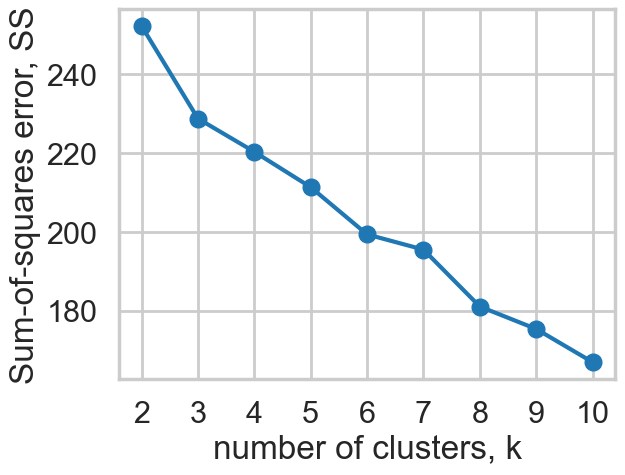

In [108]:
ks = list(range(2, 11))
ss = []

assignments = {}

for k in ks:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X)
    assigned_cluster = model.predict(X)
    centers = model.cluster_centers_
    ssk = np.sum((X - centers[assigned_cluster])**2)
    ss.append(ssk)
    assignments[str(k)] = assigned_cluster


plt.plot(ks, ss, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('Sum-of-squares error, SS')
plt.xticks(ks)
plt.show()


<b><li> Make a bar chart showing the number of points in each cluster for k-means under the best $K$.</b>

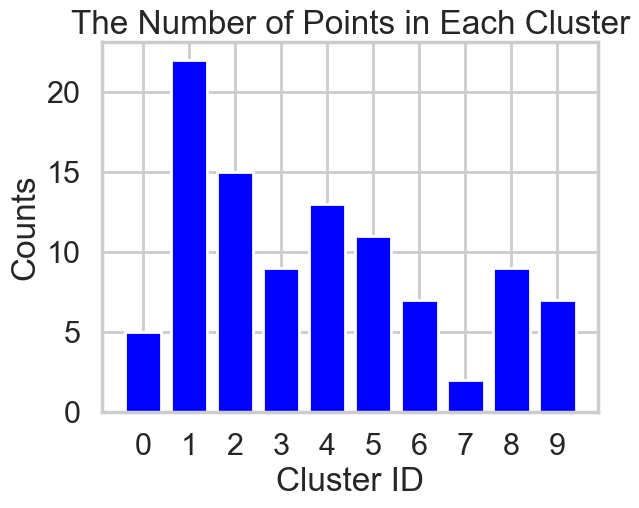

In [109]:
import numpy as np
bestk = 10
model_k10 = KMeans(n_clusters=bestk, random_state=42)
model_k10.fit(X)
labels_k10 = model_k10.predict(X)

cluster, counts = np.unique(labels_k10, return_counts=True)

plt.bar(cluster, counts, color='blue')
plt.xlabel('Cluster ID')
plt.ylabel('Counts')
plt.xticks(cluster)
plt.title('The Number of Points in Each Cluster')
plt.show()

<b><li> What challenges did you experience using the Elbow method to pick $K$?</b>

Identifying the Elbow point in the SS vs. K plot is challenging due to the absence of a clearly defined bend in the curve.

#### 3aii. Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

**Hint**: Scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set III</h3>

<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>
</div>

### Your turn.
<p><b>Exercise:</b> Using the documentation for the `silhouette_score` function above, construct a series of silhouette plots like the ones in the article linked above.</p>

For n_clusters = 2 The average silhouette_score is : 0.12976508334276524
The size of cluster 0 is 6
The size of cluster 1 is 94
For n_clusters = 3 The average silhouette_score is : 0.08710662290736483
The size of cluster 0 is 6
The size of cluster 1 is 70
The size of cluster 2 is 24
For n_clusters = 4 The average silhouette_score is : 0.11975644774033015
The size of cluster 0 is 6
The size of cluster 1 is 51
The size of cluster 2 is 24
The size of cluster 3 is 19
For n_clusters = 5 The average silhouette_score is : 0.09789674887986952
The size of cluster 0 is 6
The size of cluster 1 is 18
The size of cluster 2 is 15
The size of cluster 3 is 16
The size of cluster 4 is 45
For n_clusters = 6 The average silhouette_score is : 0.09901581266062229
The size of cluster 0 is 4
The size of cluster 1 is 19
The size of cluster 2 is 14
The size of cluster 3 is 16
The size of cluster 4 is 35
The size of cluster 5 is 12
For n_clusters = 7 The average silhouette_score is : 0.11343337310923207
The siz

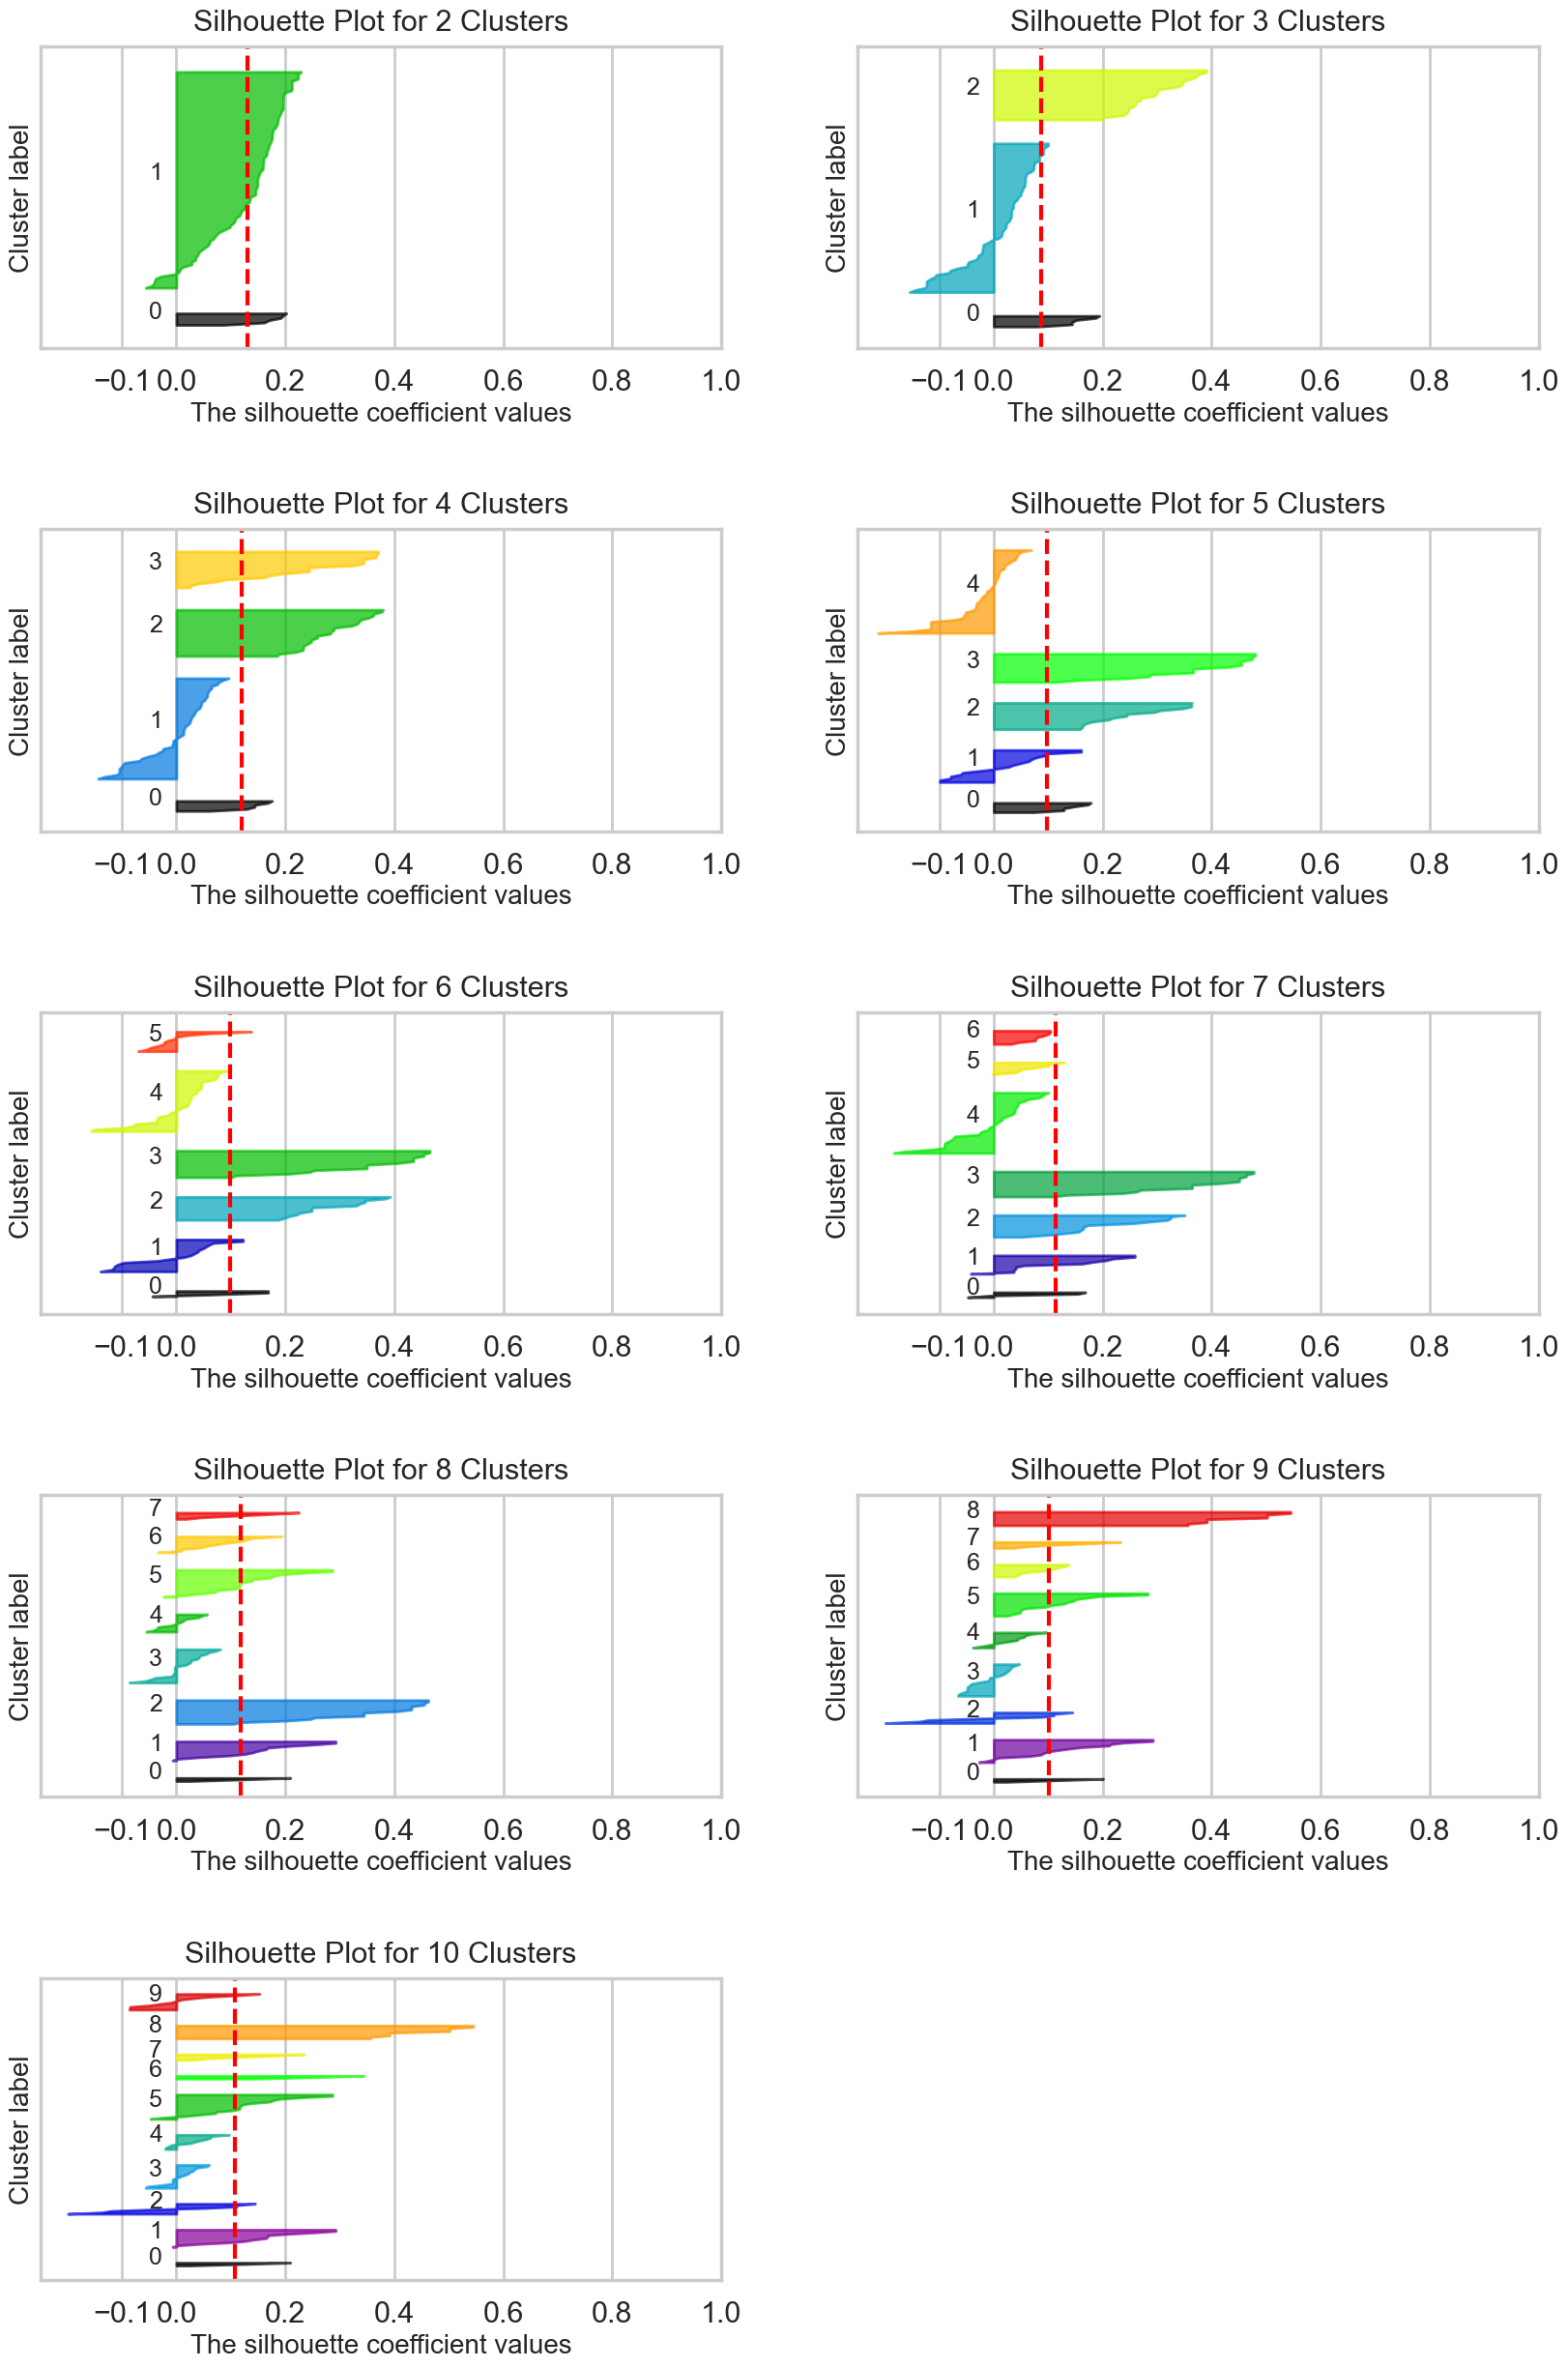

In [110]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import textwrap

silhouette_scores =[]

fig, ax = plt.subplots(5, 2, figsize=(20,30))

ax = ax.flatten()

for ind, n_clusters in enumerate(ks): 
    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax[ind].set_xlim([-0.25, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax[ind].set_ylim([0, len(X) + (n_clusters + 1) * 10])
    
    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    silhouette_scores.append(silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        print(f"The size of cluster {i} is {size_cluster_i}")
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax[ind].fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i), fontsize=18)

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    title = f"Silhouette Plot for {n_clusters} Clusters"
    ax[ind].set_title(title, pad=12, fontsize=22)
    ax[ind].set_xlabel("The silhouette coefficient values", fontsize=20)
    ax[ind].set_ylabel("Cluster label", fontsize=20)

    # The vertical line for average silhouette score of all the values
    ax[ind].axvline(x=silhouette_avg, color="red", linestyle="--")

    ax[ind].set_yticks([])  # Clear the yaxis labels / ticks
    ax[ind].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

for i in range(len(ks), len(ax)):
    fig.delaxes(ax[i])

plt.subplots_adjust(hspace=0.6, wspace=0.2)
plt.show()

<p><b>Exercise:</b> Compute the average silhouette score for each $K$ and plot it. What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?</p>

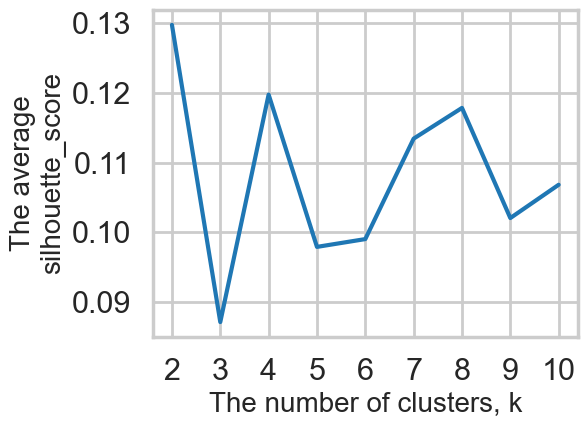

In [111]:
plt.plot(ks, silhouette_scores)
plt.xlabel('The number of clusters, k', fontsize=20)
plt.ylabel('The average\nsilhouette_score', fontsize=20)
plt.xticks(ks)
plt.tight_layout()
plt.show()

  What $K$ does the plot suggest we should choose? Does it differ from what we found using the Elbow method?
  
  This plot of the average silhouette score vs. the number of clusters suggests choosing 2 clusters, as it yields the highest average silhouette score. However, this differs from the Elbow method, which did not reveal a clear elbow point.

#### 3aiii.  Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

#### Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

**Hint:** See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

In [112]:
print(X.shape)

(100, 32)


### 3b. Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

**Hint:** PCA was discussed in the previous subunit. If you need help with it, consult [this useful article](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c) and [this visual explanation](http://setosa.io/ev/principal-component-analysis/). 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

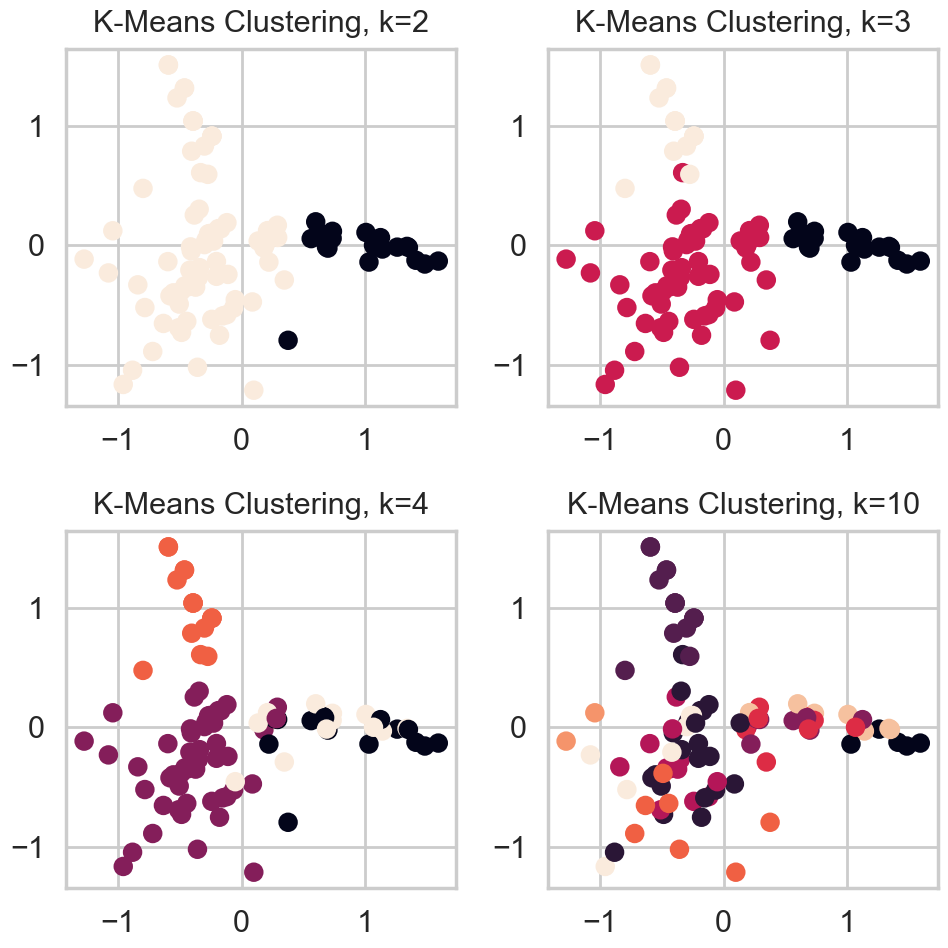

In [120]:
#your turn

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X)
transformed = pca.transform(X)
xs = transformed[:,0]
ys = transformed[:,1]

# alternative code doing the same job
#pc1, pc2 = zip(*pca.fit_transform(X))
#plt.scatter(pc1, pc2, c=cluster_assignments.tolist(), cmap=cmap)

df = pd.DataFrame({'customer_name': pivoted.index, 
                   'cluster ID': assignments['2'],
                   'x': xs,
                   'y': ys
                   })

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.flatten()

ax[0].scatter(xs, ys, c=assignments['2'])
ax[0].set_title("K-Means Clustering, k=2", pad=12, fontsize=22)

ax[1].scatter(xs, ys, c=assignments['3'])
ax[1].set_title("K-Means Clustering, k=3", pad=12, fontsize=22)

ax[2].scatter(xs, ys, c=assignments['4'])
ax[2].set_title("K-Means Clustering, k=4", pad=12, fontsize=22)

ax[3].scatter(xs, ys, c=assignments['10'])
ax[3].set_title("K-Means Clustering, k=10", pad=12, fontsize=22)

plt.tight_layout()
plt.show()

When K=2 or K=3, the clusters in the scatter plots appear well-separated, forming distinct groups. However, as K increases to 10, the clusters become more overlapping, making them difficult to distinguish. While K=10 results in the lowest sum-of-squares error among K=2-10, the excessive fragmentation leads to poor interpretability.

Considering that the average silhouette score for K=2 is higher than K=3, K=2 seems to be the optimal choice. This suggests that the silhouette method, when combined with PCA visualization, effectively identifies the best number of clusters, providing a balance between cluster separation and compactness.

In [121]:
df.head()

,customer_name,cluster ID,x,y
0,Adams,0,1.007580,0.108215
1,Allen,1,-0.287539,0.044715
2,Anderson,1,-0.392032,1.038391
3,Bailey,0,0.699477,-0.022542
4,Baker,1,0.088183,-0.471695


In [122]:
df_label = merged.merge(df, on='customer_name', how='left')
df_label

,customer_name,offer_id,n,campaign,varietal,min_qty,discount,origin,past_peak,cluster ID,x,y
0,Smith,2,1,January,Pinot Noir,72,17,France,False,1,-0.300227,0.829765
1,Smith,24,1,September,Pinot Noir,6,34,Italy,False,1,-0.300227,0.829765
2,Johnson,17,1,July,Pinot Noir,12,47,Germany,False,1,-0.461726,1.313485
3,Johnson,24,1,September,Pinot Noir,6,34,Italy,False,1,-0.461726,1.313485
4,Johnson,26,1,October,Pinot Noir,144,83,Australia,False,1,-0.461726,1.313485
...,...,...,...,...,...,...,...,...,...,...,...,...
319,Fisher,11,1,May,Champagne,72,85,France,False,1,-0.509137,-0.687321
320,Fisher,22,1,August,Champagne,72,63,France,False,1,-0.509137,-0.687321
321,Fisher,28,1,November,Cabernet Sauvignon,12,56,France,True,1,-0.509137,-0.687321
322,Fisher,30,1,December,Malbec,6,54,France,False,1,-0.509137,-0.687321


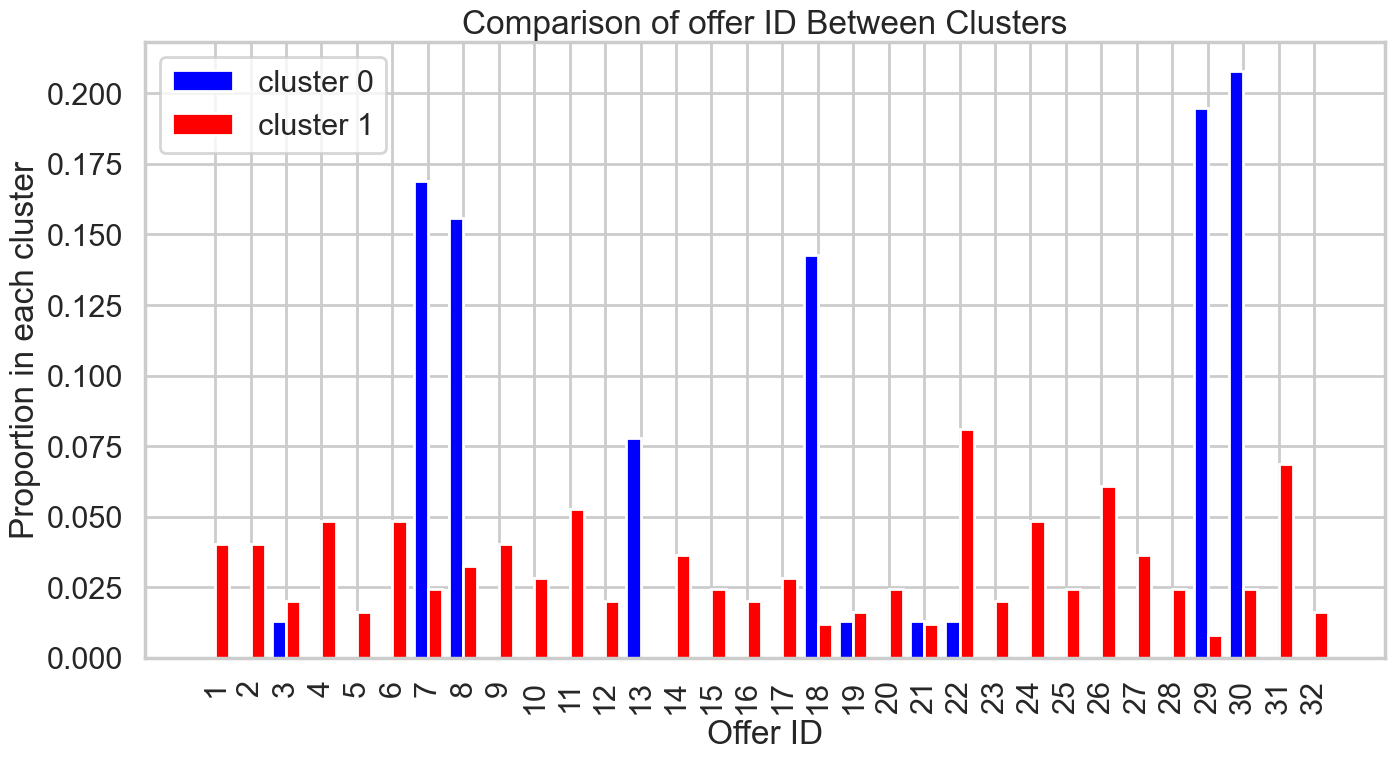

In [180]:
pivoted_offerid = df_label.pivot_table(values='n', index='cluster ID', columns='offer_id', aggfunc="sum", fill_value=0)
pivoted_offerid_nm = pivoted_offerid.div(pivoted_offerid.sum(axis=1), axis=0)

# Convert column names to integers (if they are offer IDs)
x = np.arange(len(pivoted_offerid_nm.columns))
# Bar width for side-by-side comparison
width = 0.4

plt.figure(figsize=(16, 8))
plt.bar(x - width/2, pivoted_offerid_nm.loc[0], width=width, color='blue', label='cluster 0')
plt.bar(x + width/2, pivoted_offerid_nm.loc[1], width=width, color='red', label='cluster 1')

# Set x-axis labels to original column names
plt.xticks(x, pivoted_offerid_nm.columns, rotation=90) 

# Labels and legend
plt.xlabel("Offer ID")
plt.ylabel("Proportion in each cluster")
plt.title("Comparison of offer ID Between Clusters")
plt.legend()

plt.show()


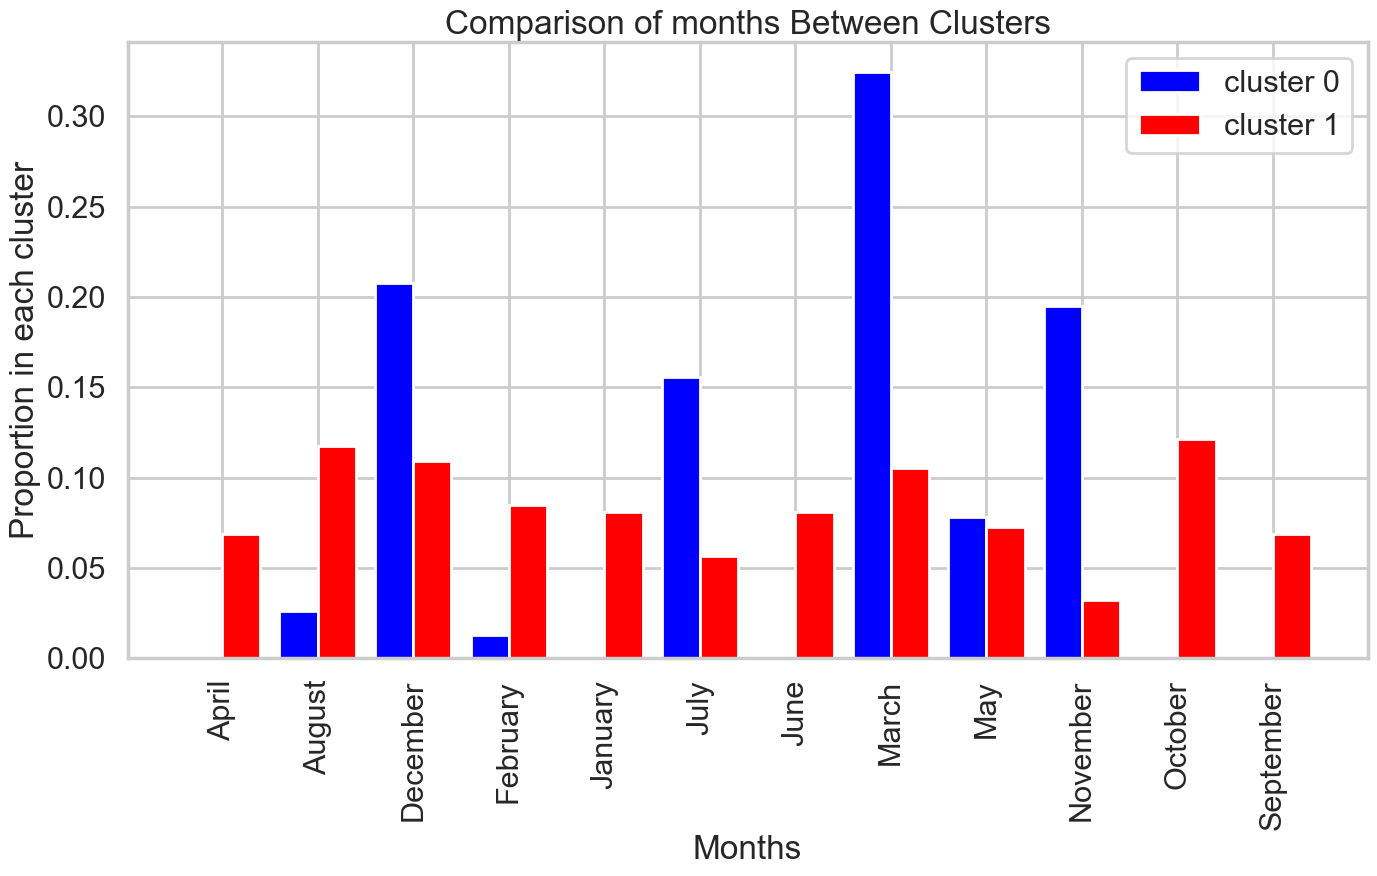

In [174]:
pivoted_camp = df_label.pivot_table(values='n', index='cluster ID', columns='campaign', aggfunc="sum", fill_value=0)
pivoted_camp_nm = pivoted_camp.div(pivoted_camp.sum(axis=1), axis=0)

# Convert column names to integers (if they are offer IDs)
x = np.arange(len(pivoted_camp_nm.columns))
# Bar width for side-by-side comparison
width = 0.4

plt.figure(figsize=(16, 8))
plt.bar(x - width/2, pivoted_camp_nm.loc[0], width=width, color='blue', label='cluster 0')
plt.bar(x + width/2, pivoted_camp_nm.loc[1], width=width, color='red', label='cluster 1')

# Set x-axis labels to original column names
plt.xticks(x, pivoted_camp_nm.columns, rotation=90) 

# Labels and legend
plt.xlabel("Months")
plt.ylabel("Proportion in each cluster")
plt.title("Comparison of months Between Clusters")
plt.legend()

plt.show()

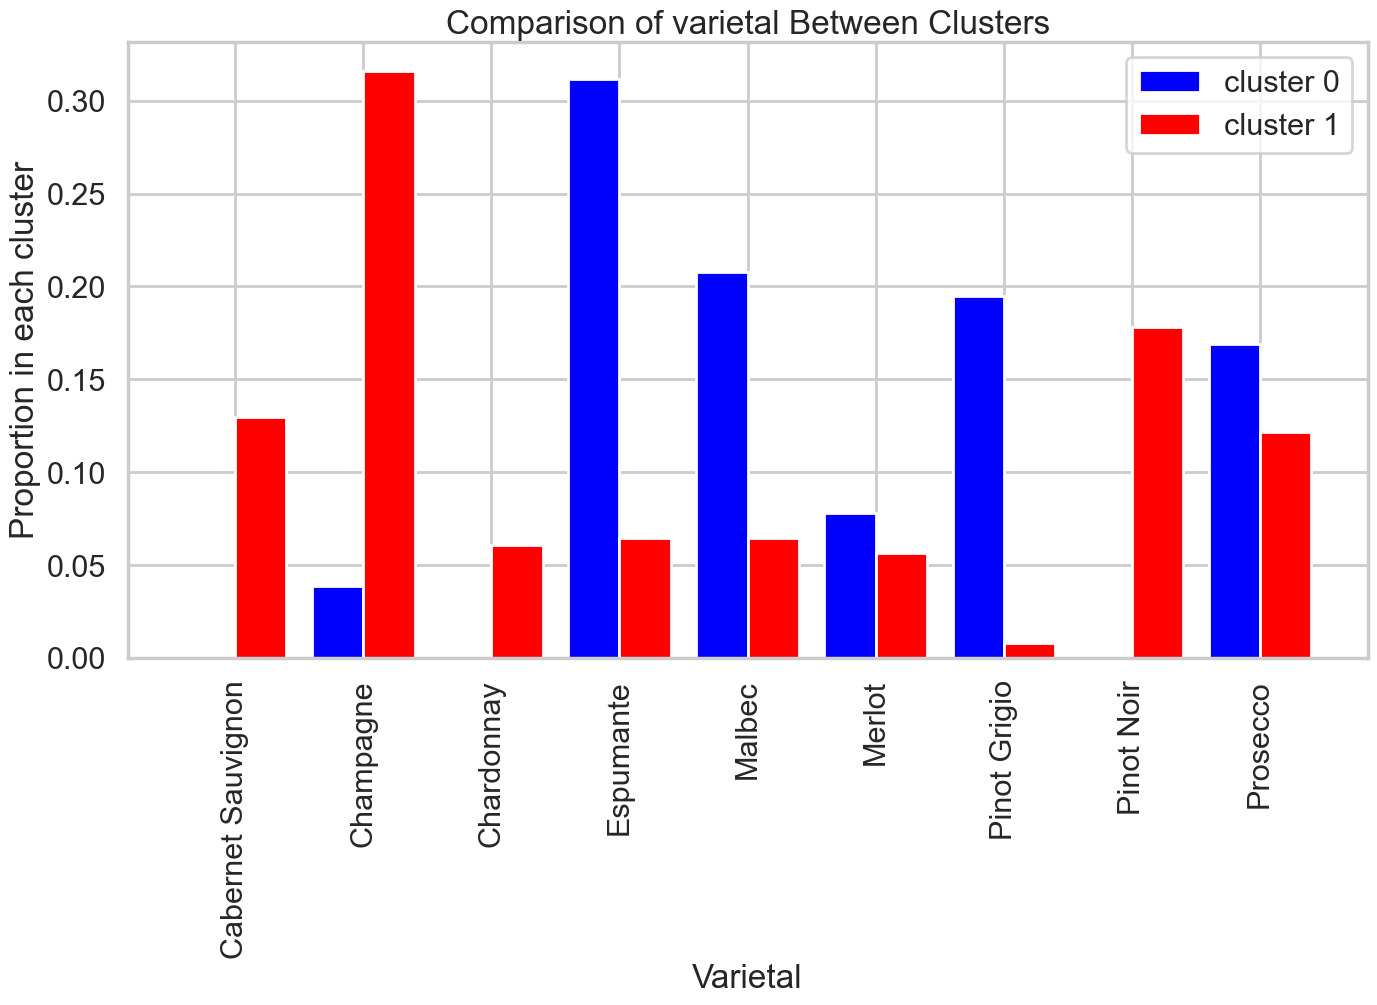

varietal,Cabernet Sauvignon,Champagne,Chardonnay,Espumante,Malbec,Merlot,Pinot Grigio,Pinot Noir,Prosecco
cluster ID,,,,,,,,,
0,0.000000,0.038961,0.000000,0.311688,0.207792,0.077922,0.194805,0.000000,0.168831
1,0.129555,0.315789,0.060729,0.064777,0.064777,0.056680,0.008097,0.178138,0.121457


In [181]:
pivoted_vari = df_label.pivot_table(values='n', index='cluster ID', columns='varietal', aggfunc="sum", fill_value=0)
pivoted_vari_nm = pivoted_vari.div(pivoted_vari.sum(axis=1), axis=0)

# Convert column names to integers (if they are offer IDs)
x = np.arange(len(pivoted_vari_nm.columns))
# Bar width for side-by-side comparison
width = 0.4

plt.figure(figsize=(16, 8))
plt.bar(x - width/2, pivoted_vari_nm.loc[0], width=width, color='blue', label='cluster 0')
plt.bar(x + width/2, pivoted_vari_nm.loc[1], width=width, color='red', label='cluster 1')

# Set x-axis labels to original column names
plt.xticks(x, pivoted_vari_nm.columns, rotation=90) 

# Labels and legend
plt.xlabel("Varietal")
plt.ylabel("Proportion in each cluster")
plt.title("Comparison of varietal Between Clusters")
plt.legend()

plt.show()

pivoted_vari_nm

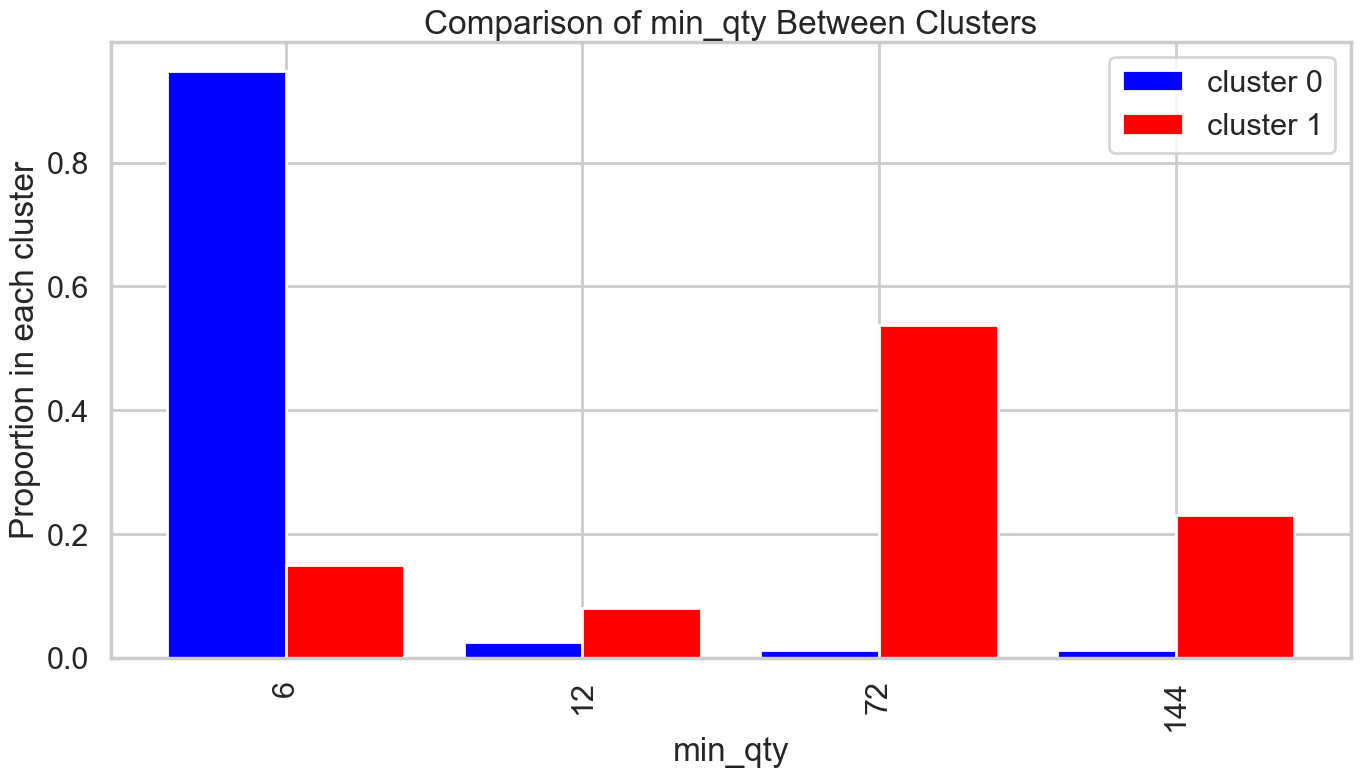

min_qty,6,12,72,144
cluster ID,,,,
0,0.948052,0.025974,0.012987,0.012987
1,0.149798,0.080972,0.538462,0.230769


In [176]:
pivoted_minq = df_label.pivot_table(values='n', index='cluster ID', columns='min_qty', aggfunc="sum", fill_value=0)
pivoted_minq_nm = pivoted_minq.div(pivoted_minq.sum(axis=1), axis=0)

# Convert column names to integers (if they are offer IDs)
x = np.arange(len(pivoted_minq_nm.columns))
# Bar width for side-by-side comparison
width = 0.4

plt.figure(figsize=(16, 8))
plt.bar(x - width/2, pivoted_minq_nm.loc[0], width=width, color='blue', label='cluster 0')
plt.bar(x + width/2, pivoted_minq_nm.loc[1], width=width, color='red', label='cluster 1')

# Set x-axis labels to original column names
plt.xticks(x, pivoted_minq_nm.columns, rotation=90) 

# Labels and legend
plt.xlabel("min_qty (kg)")
plt.ylabel("Proportion in each cluster")
plt.title("Comparison of min_qty Between Clusters")
plt.legend()

plt.show()

pivoted_minq_nm

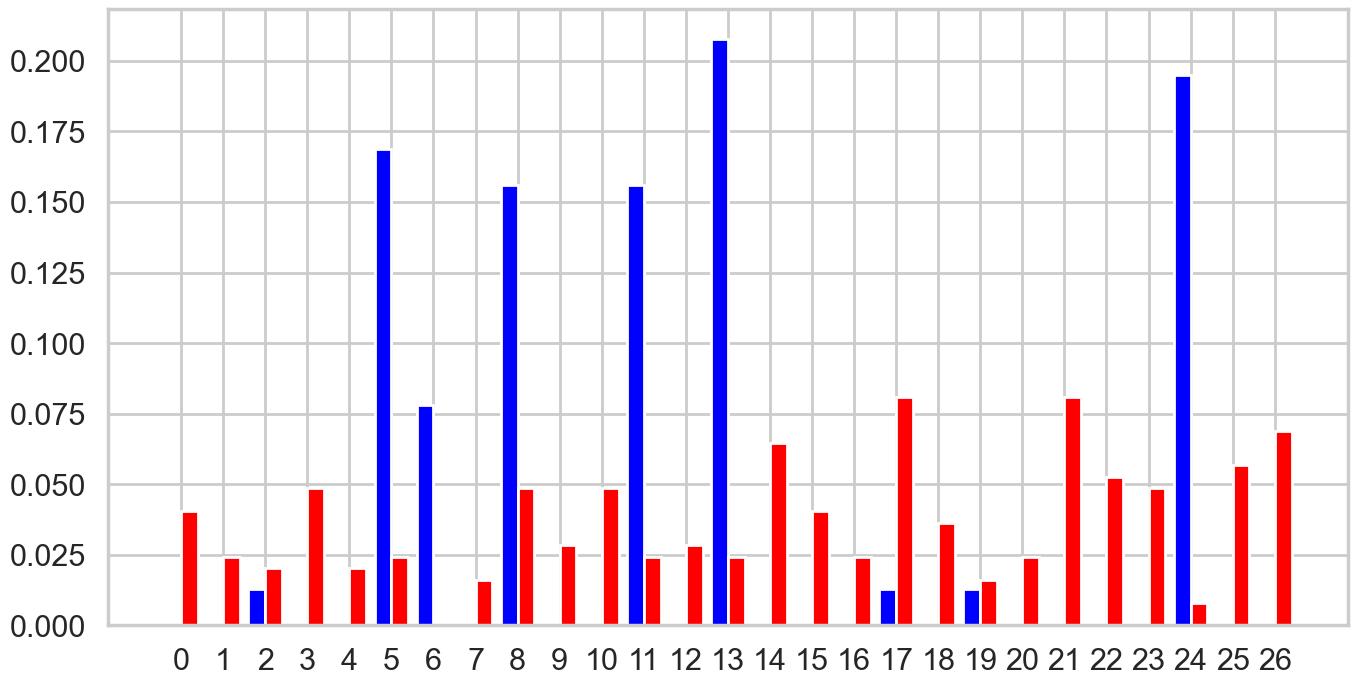

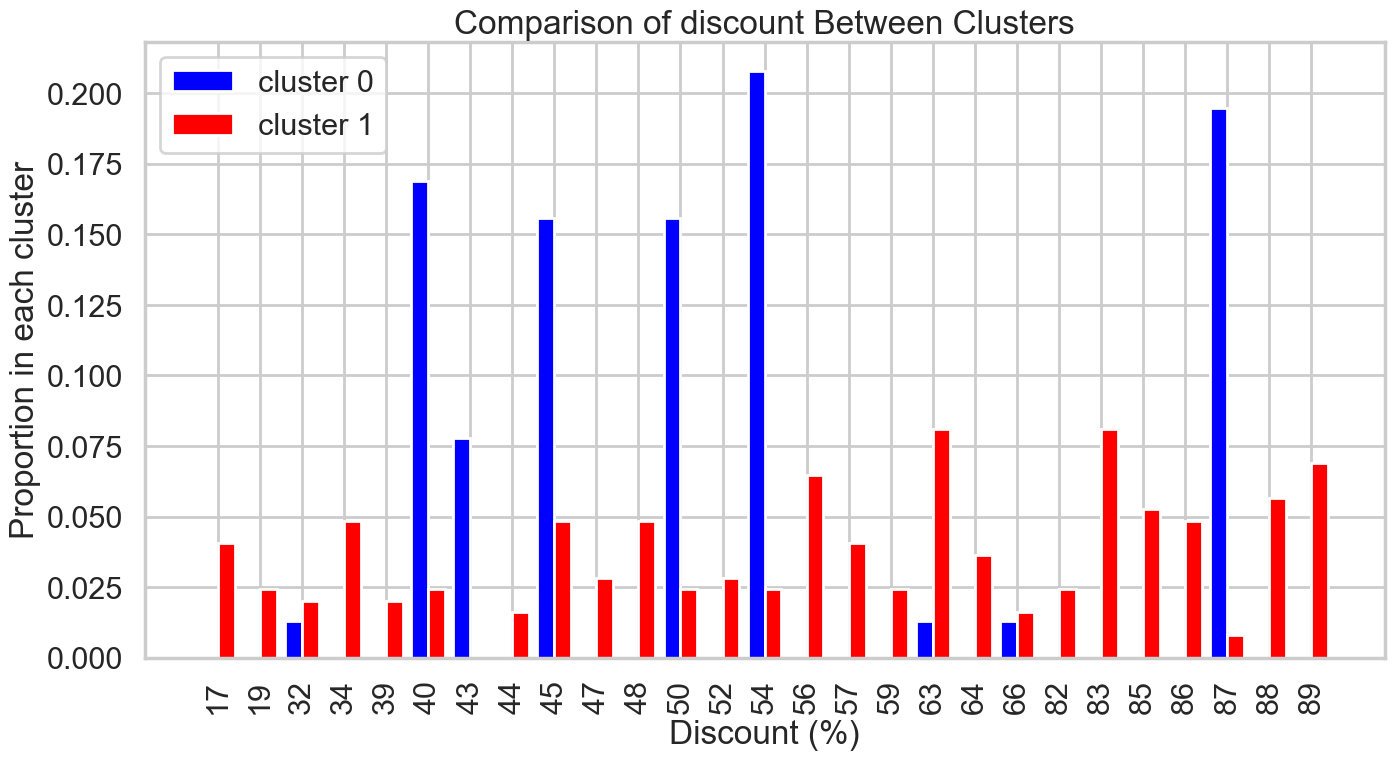

discount,17,19,32,34,39,40,43,44,45,47,48,50,52,54,56,57,59,63,64,66,82,83,85,86,87,88,89
cluster ID,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.000000,0.012987,0.000000,0.000000,0.168831,0.077922,0.000000,0.155844,0.00000,0.000000,0.155844,0.00000,0.207792,0.000000,0.000000,0.000000,0.012987,0.000000,0.012987,0.000000,0.000000,0.000000,0.000000,0.194805,0.00000,0.000000
1,0.040486,0.024291,0.020243,0.048583,0.020243,0.024291,0.000000,0.016194,0.048583,0.02834,0.048583,0.024291,0.02834,0.024291,0.064777,0.040486,0.024291,0.080972,0.036437,0.016194,0.024291,0.080972,0.052632,0.048583,0.008097,0.05668,0.068826


In [178]:
pivoted_disc = df_label.pivot_table(values='n', index='cluster ID', columns='discount', aggfunc="sum", fill_value=0)
pivoted_disc_nm = pivoted_disc.div(pivoted_disc.sum(axis=1), axis=0)

# Convert column names to integers (if they are offer IDs)
x = np.arange(len(pivoted_disc_nm.columns))
# Bar width for side-by-side comparison
width = 0.4

plt.figure(figsize=(16, 8))
plt.bar(x - width/2, pivoted_disc_nm.loc[0], width=width, color='blue', label='cluster 0')
plt.bar(x + width/2, pivoted_disc_nm.loc[1], width=width, color='red', label='cluster 1')

# Set x-axis labels to original column names
plt.xticks(x, pivoted_disc_nm.columns, rotation=90) 

# Labels and legend
plt.xlabel("Discount (%)")
plt.ylabel("Proportion in each cluster")
plt.title("Comparison of discount Between Clusters")
plt.legend()

plt.show()


pivoted_disc_nm

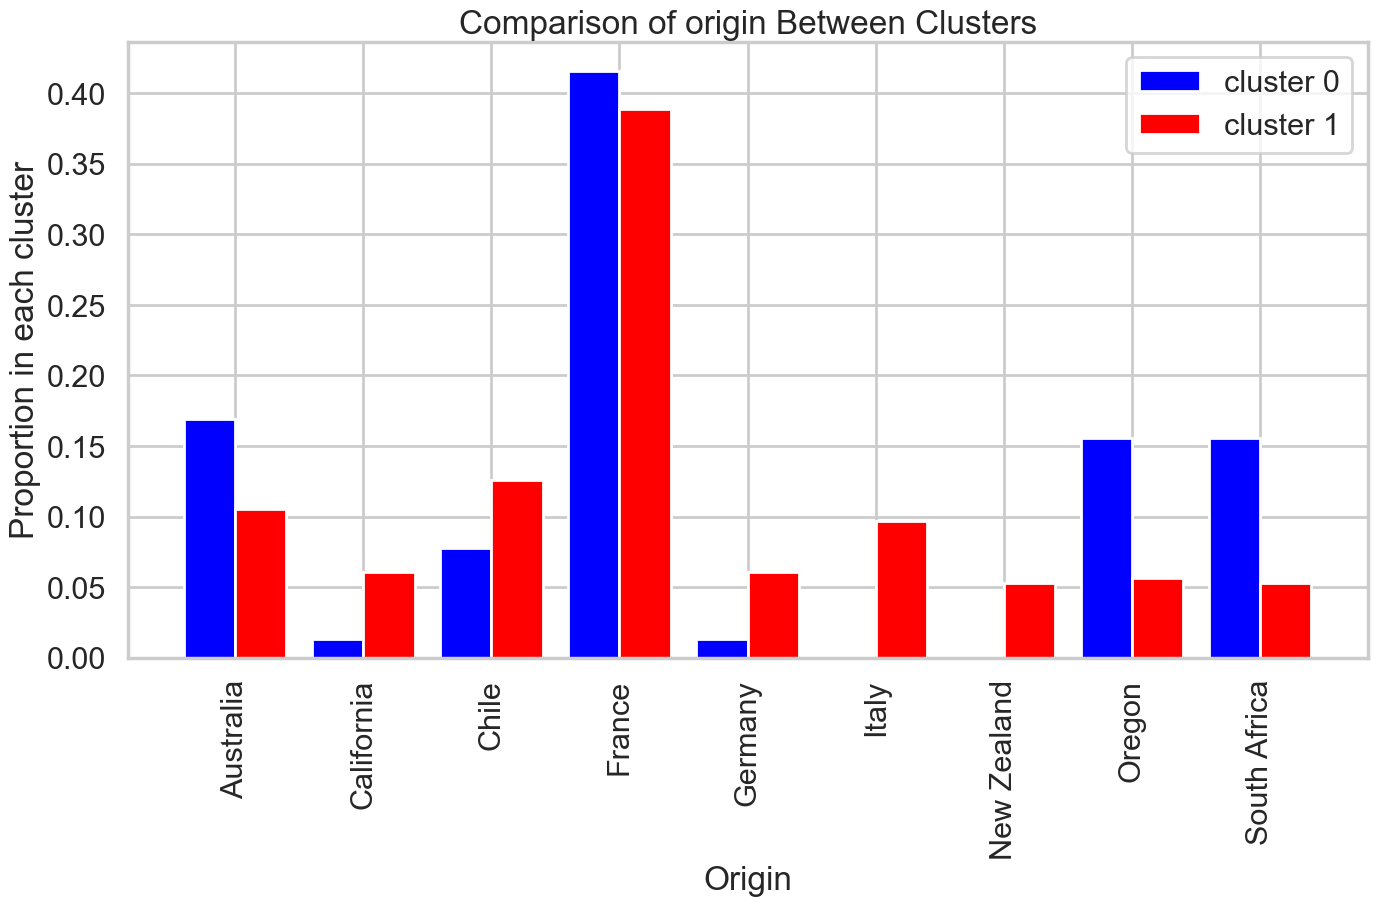

origin,Australia,California,Chile,France,Germany,Italy,New Zealand,Oregon,South Africa
cluster ID,,,,,,,,,
0,0.168831,0.012987,0.077922,0.415584,0.012987,0.000000,0.000000,0.155844,0.155844
1,0.105263,0.060729,0.125506,0.388664,0.060729,0.097166,0.052632,0.056680,0.052632


In [182]:
pivoted_orig = df_label.pivot_table(values='n', index='cluster ID', columns='origin', aggfunc="sum", fill_value=0)
pivoted_orig_nm = pivoted_orig.div(pivoted_orig.sum(axis=1), axis=0)

# Convert column names to integers (if they are offer IDs)
x = np.arange(len(pivoted_orig_nm.columns))
# Bar width for side-by-side comparison
width = 0.4

plt.figure(figsize=(16, 8))
plt.bar(x - width/2, pivoted_orig_nm.loc[0], width=width, color='blue', label='cluster 0')
plt.bar(x + width/2, pivoted_orig_nm.loc[1], width=width, color='red', label='cluster 1')

# Set x-axis labels to original column names
plt.xticks(x, pivoted_orig_nm.columns, rotation=90) 

# Labels and legend
plt.xlabel("Origin")
plt.ylabel("Proportion in each cluster")
plt.title("Comparison of origin Between Clusters")
plt.legend()

plt.show()


pivoted_orig_nm

### Comments: 
The clustering analysis reveals two distinct customer segments based on their wine purchasing behavior. Cluster 0 (Blue) represents casual, price-sensitive buyers who prefer a mix of different wine varietals, including Espumante, Malbec, Merlot, and Chardonnay. They tend to buy in small quantities (6 bottles). Their purchases peak in March, December, and June, suggesting they may be influenced by seasonal promotions or holidays. Additionally, they show a diverse interest in wines from Australia, Germany, Italy, and Chile, indicating an openness to international varieties. Overall, these customers may include occasional drinkers, budget-conscious consumers, or those looking for deals on different wines.

Cluster 1 (Red) consists of bulk, premium buyers who overwhelmingly prefer French wines, particularly Champagne and Prosecco. These customers are more likely to purchase in large quantities (72 or 144 bottles) and have a steadier buying pattern across different months, with peaks in August and other scattered times of the year. Unlike Cluster 0, they are less influenced by discounts, suggesting that factors such as brand loyalty or specific preferences drive their purchasing decisions. This group likely includes high-end consumers, event organizers, businesses, or collectors who are willing to invest in premium wines in large quantities. Businesses could leverage these insights by targeting Cluster 0 with attractive discounts and seasonal promotions, while offering exclusive premium selections or bulk deals to Cluster 1.

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

<div class="span5 alert alert-info">
<h3>Exercise Set V</h3>

<p>As we saw earlier, PCA has a lot of other uses. Since we wanted to visualize our data in 2 dimensions, restricted the number of dimensions to 2 in PCA. But what is the true optimal number of dimensions?</p>

<p><b>Exercise:</b> Using a new PCA object shown in the next cell, plot the `explained_variance_` field and look for the elbow point, the point where the curve's rate of descent seems to slow sharply. This value is one possible value for the optimal number of dimensions. What is it?</p>
</div>

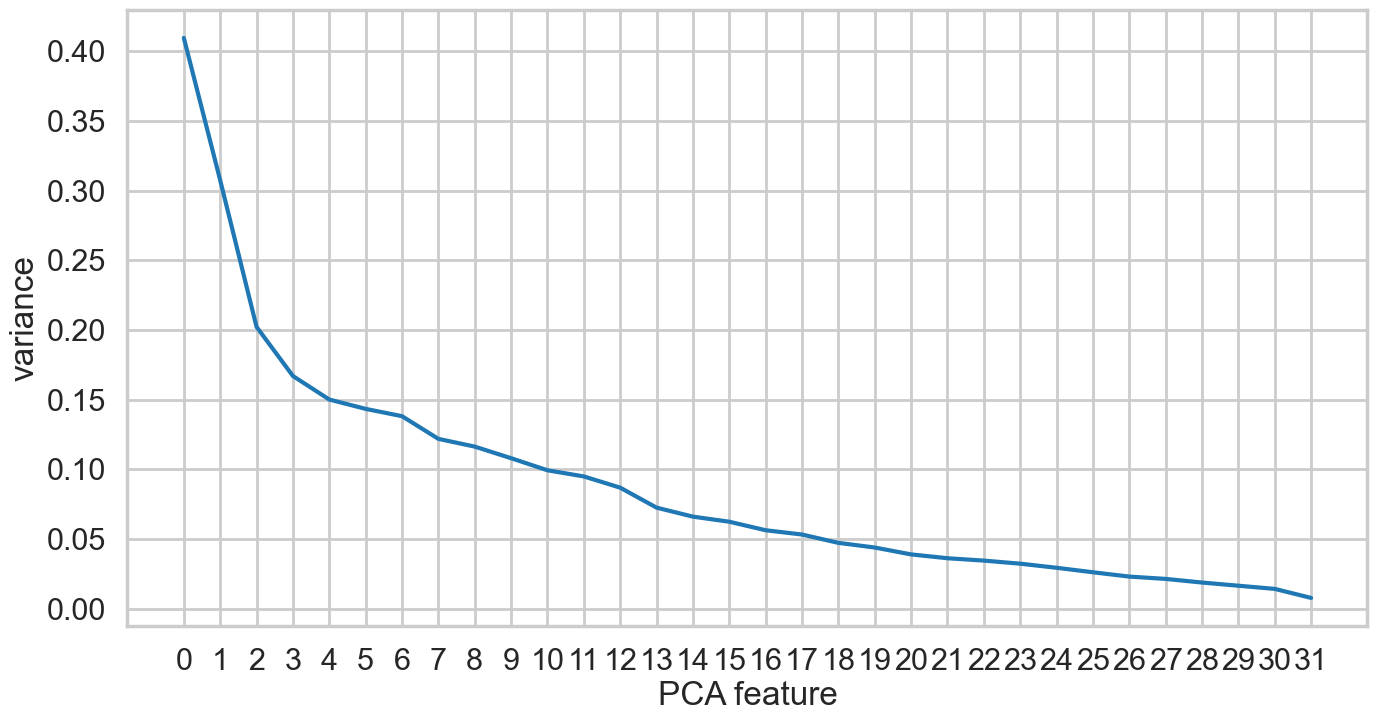

In [189]:
#your turn
# Initialize a new PCA model with a default number of components.
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X)

# Do the rest on your own :)
plt.figure(figsize=(16, 8))
features = range(pca.n_components_)
plt.plot(features, pca.explained_variance_)
plt.xticks(features)
plt.ylabel('variance')
plt.xlabel('PCA feature')
plt.show()


It appears that the elbow point is at feature 3, indicating that the optimal number of dimensions is 4.

## 4. Conclusions and next steps
### 4a. Conclusions
What can you conclude from your investigations? Make a note, formulate it as clearly as possible, and be prepared to discuss it with your mentor in your next call. 

### 4b. Other clustering algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

<div class="span5 alert alert-info">
<h3>Exercise Set VI</h3>

<p><b>Exercise:</b> Try clustering using the following algorithms. </p>
<ol>
<li>Affinity propagation
<li>Spectral clustering
<li>Agglomerative clustering
<li>DBSCAN
</ol>
<p>How do their results compare? Which performs the best? Tell a story why you think it performs the best.</p>
</div>


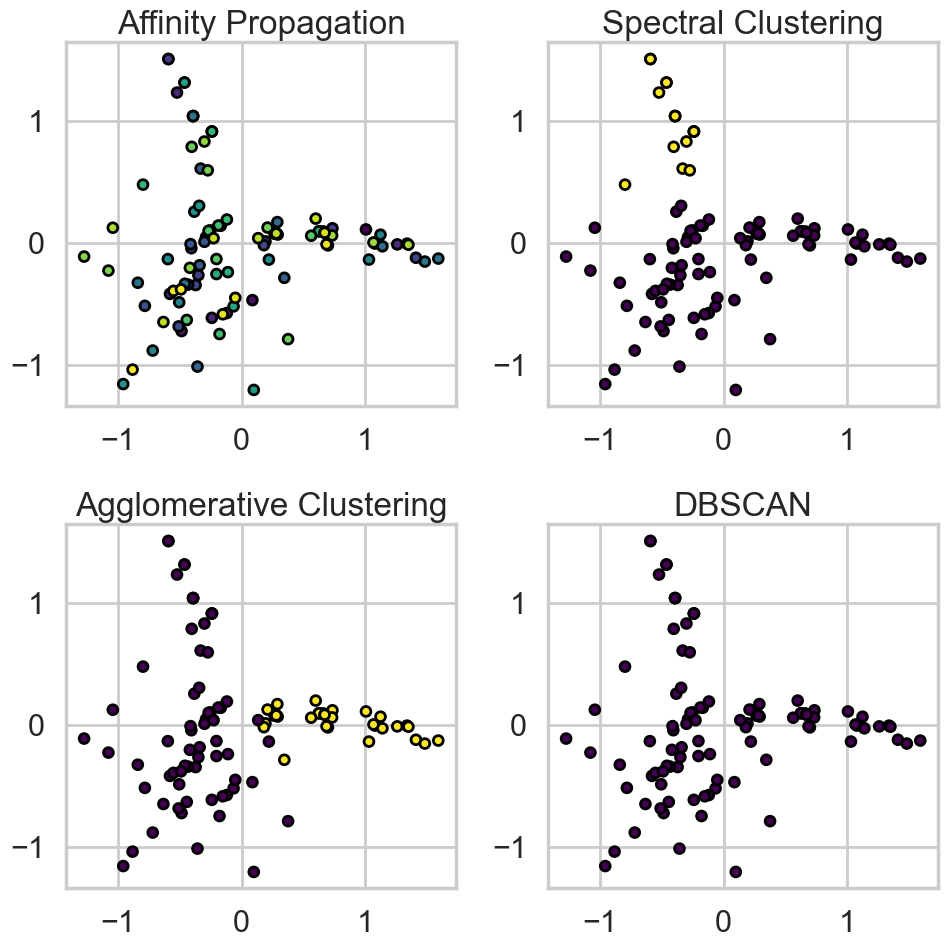

In [191]:
# Your turn
from sklearn.cluster import AffinityPropagation, SpectralClustering, AgglomerativeClustering, DBSCAN

pca = PCA(n_components=2)
pca.fit(X)
transformed = pca.transform(X)

models={
    "Affinity Propagation": AffinityPropagation(damping=0.9, preference=50, random_state=42),
    "Spectral Clustering": SpectralClustering(n_clusters=2, affinity='nearest_neighbors', random_state=42),
    "Agglomerative Clustering": AgglomerativeClustering(n_clusters=2),
    "DBSCAN": DBSCAN(eps=0.3, min_samples=5)
}


fig, axes = plt.subplots(2, 2, figsize=(10,10))
axes = axes.flatten()

for i, (name, model) in enumerate(models.items()):
    labels = model.fit_predict(X)

    axes[i].scatter(transformed[:,0], transformed[:,1], c=labels, cmap='viridis', edgecolor='k', s=50)
    axes[i].set_title(name)

plt.tight_layout()
plt.show()


### Comments:

Based on the initial parameter settings for each model, Agglomerative Clustering performs the best, as it produces a clustering structure similar to K-Means at its optimal kk value ( k=2k=2 ). Spectral Clustering forms two well-separated clusters; however, the most distinct cluster on the right fails to be properly separated. Affinity Propagation results in completely overlapping clusters, while DBSCAN treats the entire dataset as a single cluster.